The goal of this project is to "segment" customer data from an online store into a kind of customer ranking. The dataset is the [Online Retail Dataset](https://http://archive.ics.uci.edu/ml/datasets/online+retail "Online Retail Data Set") from UCI's Machine Learning Repository. I followed this [tutorial](https://www.datacamp.com/community/tutorials/introduction-customer-segmentation-python "Datacamp") from Datacamp for this project.

Here's a link to the [Jupyter Notebook](https://github.com/illesial/illesial.github.io/blob/master/customer_segmentation.ipynb) for this project.

We'll rank customers according to three metrics - Recency, Frequency, and Monetary (R, F, and M), which will be combined into a single score called RFM.
<!--excerpt-->

Recency means how recently the customer purchased something. Frequency means how frequently the customer purchased items, which means we'll calculate the total number of purchases for frequency. Finally, monetary is the total amount of money the customer spent. Between these three values, we can determine who has spent a lot, who buys often, and who bought items in the recent past. 

In order to produce our combined RFM score, we'll want to first calculate our Recency, Frequency, and Monetary columns. After that, we'll want to rank customers according to each metric by calculating quartiles for each. Therefore a "top" customer will be in the first quartile for all three - they will have bought recently, bought frequently, and spent big. 

## Loading and Cleaning Data

We'll begin by importing packages: `pandas` as usual, `datetime` for our temporal processing, and `matplotlib` and `seaborn` for plotting. We'll follow that by loading the data from the excel file `online_retail.xlsx` as a dataframe and inspecting it using `pd.head()`:

In [1]:
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt

In [2]:
data = pd.read_excel("online_retail_data\online_retail.xlsx")

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


We see upon inspection that our data includes, among other things, Country of origin, CustomerID,  UnitPrice, Quantity, and InvoiceDate. These last four columns are what we'll use to calculate, by customer, our RFM score as outlined above.

First, however, we should clean our data a little bit. A quick check using `pd.info()` shows that the CustomerID has lots of null entries:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB


We'll remedy this by using `pd.notnull()` on the `CustomerID` column:

In [4]:
data = data[pd.notnull(data['CustomerID'])]

Next, we'll inspect the data for other invalid values. We'll call `pd.describe()` and inspect:

In [19]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


We see that the Quantity column has some negative values, which shouldn't be possible. Therefore we'll filter them out. We'll also drop any duplicate records:

In [5]:
data=data[(data['Quantity'] >0)]
data = data.drop_duplicates()

## Calculating our metrics: Recency, Frequency, and Monetary

Next we'll need to calculate our metrics. We'll start with Monetary, which is just the total price, i.e. Quantity * UnitPrice for each CustomerID:

In [6]:
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

We'll later total this column and rename it to Monetary. Next let's figure out what range of dates we're working with:

In [7]:
data['InvoiceDate'].min(), data['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

Looks like the most recent transaction in the data is on December 9th, 2011. It therefore makes sense to set the `PRESENT` to the following day. We'll also convert our InvoiceDate column to DateTimeIndex using `pd.to_datetime()`:

In [8]:
PRESENT = dt.datetime(2011,12,10)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

We'll proceed by calculating our Recency, Frequency, and Monetary values for each customer. We'll `groupby` the CustomerID column and aggregate by calculating the number of days since the present, calculate the number of transactions, and summing up the prices:

In [9]:
rfm= data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})

Finally we have our Recency, Frequency, and Monetary values; let's rename our columns as such. We'll also change the type of recency to `int`:

In [10]:
rfm.columns = ['recency','frequency','monetary']
rfm['recency'] = rfm['recency'].astype(int)

Let's take a look at our `rfm` dataframe using `pd.head()`:

In [27]:
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


## Calculating the RFM Score

We see that `rfm` is a dataframe indexed by CustomerID, with columns for our Recency, Frequency, and Monetary scores. Let's break these scores down into ranked groups (i.e. quartiles) using `pd.qcut()`:

In [11]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])

Notice that the labels for recency are in reversed order in comparison with those for frequency and monetary. That's because we want to rank more highly those customers who made purchases more recently (i.e. fewer days since the present), while also ranking highly those customers who spend frequently and in large quantities. 

Let's proceed by inspecting `rfm` using `pd.head()`:

In [12]:
rfm.head()

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,1,77183,4,4,1
12347.0,2,182,4309,4,1,4
12348.0,75,31,1797,4,3,2
12349.0,18,73,1757,4,2,3
12350.0,310,17,334,2,4,1


We now have recency, frequency, and monetary rankings for each customer in the columns `r_quartile`, `f_quartile`, and `m_quartile` respectively. Let's finally combine these into one combined RFM score. We'll do this by just concatenating these scores into one string:

In [12]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)

In [30]:
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
12346.0,325,1,77183.60,4,4,1,441
12347.0,2,182,4310.00,1,1,1,111
12348.0,75,31,1797.24,3,3,1,331
12349.0,18,73,1757.55,2,2,1,221
12350.0,310,17,334.40,4,4,3,443


After inspecting our work, we can see our RFM score in the column `RFM_Score`. We can see that one customer has an RFM score of `111`, which  means that customer ranks highly in all aspects: has purchased recently, frequently, and has spent a lot. We can sort customers by `RFM_Score` to see who else has a score of `111`:

In [13]:
rfm.sort_values('RFM_Score').head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
16379.0,4,108,2157.40,1,1,1,111
14868.0,3,144,2953.59,1,1,1,111
17651.0,11,232,3945.00,1,1,1,111
18041.0,11,458,4097.37,1,1,1,111
16678.0,2,163,3109.99,1,1,1,111


Let's write our work to a file `rfm.csv` using `pd.to_csv()`:

In [14]:
rfm.to_csv('rfm.csv')

## Customer Segmentation via RFM Score: Analysis and Visualization

We can calculate how many customers have this score:

In [13]:
print(rfm['RFM_Score'].value_counts()['111'])
print(len(rfm.index))

443
4339


It looks like 443 customers out of 4339 have the top RFM score, or about 10%. Next, let's make a plot of our data. We'll put Frequency on one axis, Monetary on another axis, and color points according to the recency score. Before doing so, let's filter out some outliers to make the plot a little more viewable.

In [16]:
### FILTERING OUT SOME OUTLIERS TO MAKE PLOT MORE READABLE
rfm_truncated = rfm[rfm['frequency'] < 2000]
rfm_truncated = rfm_truncated[rfm_truncated['monetary'] < 100000]

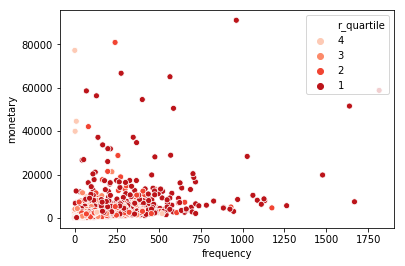

In [27]:
plt.clf()
ax = sns.scatterplot(x="frequency", y="monetary", hue="r_quartile", data=rfm_truncated, palette=sns.color_palette("Reds", 4), hue_order=['4','3','2','1'])
plt.show()

In the above plot, the darkest red dots are the top scoring customers by recency. Let's proceed by filtering out those customers not scoring a `1` into a dataframe `rfm_topfreq`:

In [17]:
### FILTER OUT NON-TOP FREQ
rfm_topfreq = rfm_truncated[rfm_truncated['r_quartile'] == '1']

Finally we'll overlay boundary lines that denote customers who scored the highest Monetary and Frequency scores: the values used below are the top quartiles for each of the Monetary and Frequency variables:

In [18]:
import numpy as np

In [19]:
#freq_bdry_x= 98*np.ones(len(freq_bdry_y))
bdry_x = range(98, 2000)
bdry_y1 = 1660*np.ones(len(bdry_x))
bdry_y2 = 100000*np.ones(len(bdry_x))

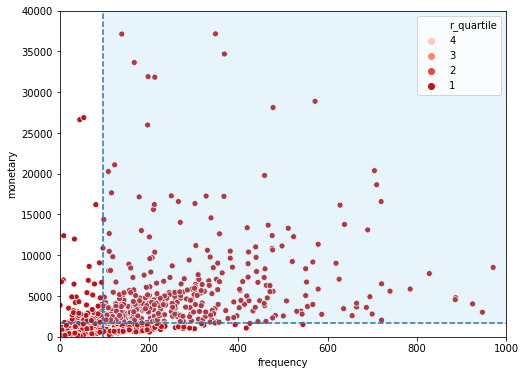

In [28]:
plt.clf()
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x="frequency", y="monetary", hue="r_quartile", data=rfm_topfreq, palette=sns.color_palette("Reds", 4), hue_order=['4','3','2','1'])
ax.axvline(x=98, linestyle='--')
ax.axhline(y=1660, linestyle='--')
ax.set(ylim=(0, 40000))
ax.set(xlim=(0, 1000))
plt.fill_between(bdry_x, bdry_y1, y2=bdry_y2, color="skyblue", alpha=0.2)
plt.show()

I think from this plot alone, one could imagine some better methods being used to segment customers from this data. 